# Midiendo rendimiento y riesgo con datos históricos

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/7/7d/Copper_Price_History_USD.png" width="600px" height="400px" />

> Ya sabemos que podemos caracterizar la distribución de rendimientos de un activo mediante una medida de tendencia central (media: rendimiento esperado) y una medida de dispersión (desviación estándar: volatilidad). 

> En la clase pasada vimos como obtener reportes históricos de precios de activos. ¿Cómo usamos estos históricos para medir el rendimiento esperado y la volatilidad de los rendimientos?

*Objetivos:*
- Calcular los rendimientos a partir de históricos de precios.
- Estimar rendimiento esperado y riesgo a partir de históricos de rendimientos.
- Anualizar rendimiento y volatilidad cuando los datos están en una base de tiempo menor.
- Verificar la relación entre rendimiento y riesgo a través de datos reales.

**Referencias:**
- http://pandas.pydata.org/
- https://pandas-datareader.readthedocs.io/en/latest/
- Notas del curso "Portfolio Selection and Risk Management", Rice University, disponible en Coursera.
___

## 1. Cálculo de los rendimientos

Muy bien, ya entonces sabemos descargar históricos de precios...

**Ejemplo:** trabajaremos esta clase con activos que se encuentran en el top-10 del índice S&P500. Descargar precios ajustados en el cierre de Microsoft (MSFT), Apple (AAPL), Amazon (AMZN), Facebook (FB) y Alphabet Inc. (GOOGL) desde el primero de enero del 2015 hasta hoy.

In [1]:
# Importar paquetes
import pandas_datareader.data as web
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [3]:
# Información
names = ['MSFT', 'AAPL', 'AMZN', 'FB', 'GOOGL', '^GSPC']
start_date = '2015-01-01'

In [24]:
# Precios diarios
closes = get_adj_closes(tickers=names, start_date=start_date)
closes.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-02,41.748566,99.945885,308.519989,78.449997,529.549988,2058.199951
2015-01-05,41.364658,97.130241,302.190002,77.190002,519.460022,2020.579956
2015-01-06,40.757530,97.139420,295.290009,76.150002,506.640015,2002.609985
2015-01-07,41.275364,98.501518,298.420013,76.150002,505.149994,2025.900024
2015-01-08,42.489609,102.286186,300.459991,78.180000,506.910004,2062.139893


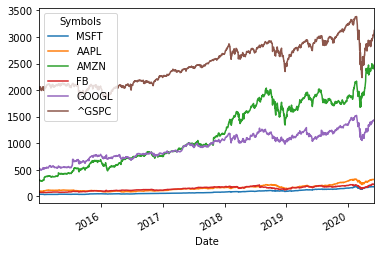

In [25]:
# Gráfico de histórico de precios diarios
closes[['MSFT', 'AAPL', 'AMZN', 'FB', 'GOOGL', '^GSPC']].plot()

### 1.1. Rendimientos porcentuales

Muy bien, pero para el análisis no trabajamos con los precios sino con los rendimientos... **¿porqué?**

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual
$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}
$$
para $t=1,\ldots,n$.

*¡Cuidado!* los rendimientos son de acuerdo a la base de tiempo en que se reportan los precios. Por ejemplo: 
- si los precios se reportan en una base diaria, los rendimientos también son diarios;
- si los precios se reportan en una base mensual, los rendimientos también son mensuales.

In [26]:
# Método shift() de un DataFrame...
help(closes.shift)

Help on method shift in module pandas.core.frame:

shift(periods=1, freq=None, axis=0, fill_value=None) method of pandas.core.frame.DataFrame instance
    Shift index by desired number of periods with an optional time `freq`.
    
    When `freq` is not passed, shift the index without realigning the data.
    If `freq` is passed (in this case, the index must be date or datetime,
    or it will raise a `NotImplementedError`), the index will be
    increased using the periods and the `freq`.
    
    Parameters
    ----------
    periods : int
        Number of periods to shift. Can be positive or negative.
    freq : DateOffset, tseries.offsets, timedelta, or str, optional
        Offset to use from the tseries module or time rule (e.g. 'EOM').
        If `freq` is specified then the index values are shifted but the
        data is not realigned. That is, use `freq` if you would like to
        extend the index when shifting and preserve the original data.
    axis : {0 or 'index', 1 or

In [30]:
closes.head(3)

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-02,41.748566,99.945885,308.519989,78.449997,529.549988,2058.199951
2015-01-05,41.364658,97.130241,302.190002,77.190002,519.460022,2020.579956
2015-01-06,40.757530,97.139420,295.290009,76.150002,506.640015,2002.609985


In [31]:
closes.shift().head(3)

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,41.748566,99.945885,308.519989,78.449997,529.549988,2058.199951
2015-01-06,41.364658,97.130241,302.190002,77.190002,519.460022,2020.579956


In [35]:
# Calcular los rendimientos
ret = (closes-closes.shift())/closes.shift()
ret.head().dropna()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,-0.009196,-0.028172,-0.020517,-0.016061,-0.019054,-0.018278
2015-01-06,-0.014677,0.000094,-0.022833,-0.013473,-0.024679,-0.008893
2015-01-07,0.012705,0.014022,0.010600,0.000000,-0.002941,0.011630
2015-01-08,0.029418,0.038422,0.006836,0.026658,0.003484,0.017888


In [36]:
# Otra forma (más fácil)
help(closes.pct_change)

Help on method pct_change in module pandas.core.generic:

pct_change(periods=1, fill_method='pad', limit=None, freq=None, **kwargs) method of pandas.core.frame.DataFrame instance
    Percentage change between the current and a prior element.
    
    Computes the percentage change from the immediately previous row by
    default. This is useful in comparing the percentage of change in a time
    series of elements.
    
    Parameters
    ----------
    periods : int, default 1
        Periods to shift for forming percent change.
    fill_method : str, default 'pad'
        How to handle NAs before computing percent changes.
    limit : int, default None
        The number of consecutive NAs to fill before stopping.
    freq : DateOffset, timedelta, or offset alias string, optional
        Increment to use from time series API (e.g. 'M' or BDay()).
    **kwargs
        Additional keyword arguments are passed into
        `DataFrame.shift` or `Series.shift`.
    
    Returns
    -------

In [37]:
ret = closes.pct_change().dropna()
ret

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,-0.009196,-0.028172,-0.020517,-0.016061,-0.019054,-0.018278
2015-01-06,-0.014677,0.000094,-0.022833,-0.013473,-0.024679,-0.008893
2015-01-07,0.012705,0.014022,0.010600,0.000000,-0.002941,0.011630
2015-01-08,0.029418,0.038422,0.006836,0.026658,0.003484,0.017888
2015-01-09,-0.008405,0.001072,-0.011749,-0.005628,-0.012211,-0.008404
...,...,...,...,...,...,...
2020-05-28,-0.002255,0.000440,-0.003854,-0.016060,-0.001436,-0.002108
2020-05-29,0.010198,-0.000974,0.017188,-0.001641,0.010774,0.004812
2020-06-01,-0.002292,0.012298,0.011739,0.030299,0.000942,0.003751


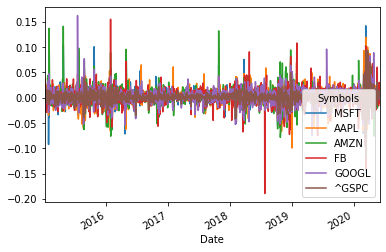

In [39]:
# Graficar...
ret.plot();

**¿Qué se observa respecto a los precios?**

Respuestas:
- Los rendimientos parecen conservar tendecias estadísticas constantes (por ejemplo, oscilan al rededor de números cercanos a cero). 

### 1.2. Rendimientos logarítmicos (log-rendimientos)

Otro rendimiento usado con frecuencia es el rendimiento continuamente compuesto o rendimiento logaritmico. Éste, está definido como

$$
r_t=\ln\left(\frac{S_t}{S_{t-1}}\right).
$$

Es fácil darse cuenta que $r_t=\ln(1+R_t)$.

<font color=blue>Ver en el tablero</font> que si $0\leq|x|\ll 1$, entonces $\ln(1+x)\approx x$.

In [42]:
# Calcular rendimientos continuamente compuestos
log_ret = np.log(closes/closes.shift()).dropna()
log_ret.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,-0.009238,-0.028576,-0.020731,-0.016191,-0.019238,-0.018447
2015-01-06,-0.014786,0.000094,-0.023098,-0.013565,-0.024989,-0.008933
2015-01-07,0.012625,0.013925,0.010544,0.000000,-0.002945,0.011563
2015-01-08,0.028994,0.037703,0.006813,0.026309,0.003478,0.017730
2015-01-09,-0.008441,0.001071,-0.011818,-0.005644,-0.012286,-0.008439


In [43]:
# Recordar rendimientos porcentuales. Ver que son similares
ret = closes.pct_change().dropna()
ret.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,-0.009196,-0.028172,-0.020517,-0.016061,-0.019054,-0.018278
2015-01-06,-0.014677,0.000094,-0.022833,-0.013473,-0.024679,-0.008893
2015-01-07,0.012705,0.014022,0.010600,0.000000,-0.002941,0.011630
2015-01-08,0.029418,0.038422,0.006836,0.026658,0.003484,0.017888
2015-01-09,-0.008405,0.001072,-0.011749,-0.005628,-0.012211,-0.008404


In [46]:
# Veamos el valor absoluto de la diferencia
np.abs(log_ret-ret).head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,0.000043,4.044356e-04,0.000213,0.000130,0.000184,0.000169
2015-01-06,0.000109,4.464215e-09,0.000265,0.000092,0.000310,0.000040
2015-01-07,0.000080,9.740020e-05,0.000056,0.000000,0.000004,0.000067
2015-01-08,0.000424,7.197628e-04,0.000023,0.000349,0.000006,0.000158
2015-01-09,0.000036,5.742497e-07,0.000070,0.000016,0.000075,0.000036


Por lo anterior, muchas veces se usan para el análisis los rendimientos continuamente compuestos.
___

## 2. Caracterización de la distribución de los rendimientos

Entonces:
- partimos de que tenemos los rendimientos porcentuales diarios de Apple, Walmart, IBM y Nike desde inicios del 2011 a finales del 2015;
- ¿cómo resumirían estos datos?

In [47]:
# Rendimiento medio diario (media aritmética)
ret.mean()

Symbols
MSFT     0.001244
AAPL     0.001026
AMZN     0.001712
FB       0.000981
GOOGL    0.000873
^GSPC    0.000375
dtype: float64

In [48]:
# Volatilidad diaria (desviación estándar)
ret.std()

Symbols
MSFT     0.017329
AAPL     0.017913
AMZN     0.019184
FB       0.019491
GOOGL    0.016759
^GSPC    0.011740
dtype: float64

In [49]:
# Podemos resumir en un DataFrame
resumen = pd.DataFrame({'R.E':ret.mean(),'Vol':ret.std()})
resumen

,R.E,Vol
Symbols,,
MSFT,0.001244,0.017329
AAPL,0.001026,0.017913
AMZN,0.001712,0.019184
FB,0.000981,0.019491
GOOGL,0.000873,0.016759
^GSPC,0.000375,0.011740


Normalmente se reportan rendimientos esperados y volatilidades en una base anual. Para anualizar:

$$E[r_a]=12E[r_m]=252E[r_d]=52E[r_w],\text{ y}$$

$$\sigma_{r_a}=\sqrt{12}\sigma_{r_m}=\sqrt{252}\sigma_{r_d}=\sqrt{52}\sigma_{r_w}$$

In [50]:
# Resumen en base anual
resumen_anual = pd.DataFrame({'R.E':ret.mean()*252,'Vol':ret.std()*(252**.5)})
resumen_anual

,R.E,Vol
Symbols,,
MSFT,0.313510,0.275096
AAPL,0.258671,0.284364
AMZN,0.431373,0.304536
FB,0.247309,0.309414
GOOGL,0.220106,0.266042
^GSPC,0.094551,0.186364


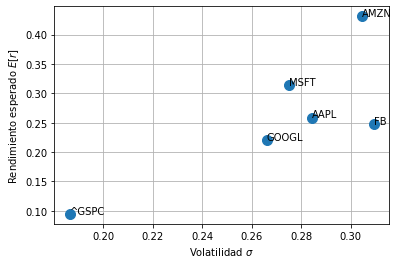

In [61]:
# Gráfico rendimiento esperado vs. volatilidad
import matplotlib.pyplot as plt
%matplotlib inline
# Puntos a graficar
# Ventana para graficar
plt.figure(figsize=(6,4))
# Graficar puntos
plt.plot(resumen_anual['Vol'],resumen_anual['R.E'],'o',ms=10)
# Etiquetas de los ejes
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento esperado $E[r]$')
# Etiqueta de cada instrumento
for i in range(len(resumen_anual)):
    plt.text(resumen_anual.iloc[i,1],resumen_anual.iloc[i,0],resumen_anual.index[i])

plt.grid()

### 2.1 Ajuste de curvas con mínimos cuadrados
Consideramos que tenemos un conjunto de n pares ordenados de datos $(\sigma_{r_i},E[r_i])$, para $i=1,2,3,\dots,n$... **en este caso corresponden a volatilidad y rendimiento esperado**

#### ¿Cuál es la recta que mejor se ajusta a estos datos?
Consideramos entonces ajustes de la forma $\hat{f}(\sigma) = \beta_0+\beta_1 \sigma = \left[1 \quad \sigma\right]\left[\begin{array}{c} \beta_0 \\ \beta_1 \end{array}\right]=\left[1 \quad \sigma\right]\boldsymbol{\beta}$ (lineas rectas).

Para decir '*mejor*', tenemos que definir algún sentido en que una recta se ajuste *mejor* que otra.

**Mínimos cuadrados**: el objetivo es seleccionar los coeficientes $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$, de forma que la función evaluada en los puntos $\sigma_{r_i}$ ($\hat{f}(\sigma_{r_i})$) aproxime los valores correspondientes $E[r_i]$.

La formulación por mínimos cuadrados, encuentra los $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$ que minimiza
$$\sum_{i=1}^{n}(E[r_i]-\hat{f}(\sigma_{r_i}))^2$$

In [54]:
# Importar el módulo optimize de la librería scipy
from scipy.optimize import minimize

In [55]:
# Funcion minimize
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

In [56]:
# Funcion objetivo y condicion inicial
def fun_obj(beta,x,y):
    recta = beta[0] + beta[1]*x
    return ((y-recta)**2).sum()

In [57]:
# Resolver problema de optimizacion
x0 = [0,0]

In [58]:
solucion = minimize(fun=fun_obj,x0=x0,args=(resumen_anual['Vol'],resumen_anual['R.E']))

In [59]:
solucion

      fun: 0.02263156517158877
 hess_inv: array([[  3.7605889 , -13.57074322],
       [-13.57074322,  50.08220627]])
      jac: array([2.32830644e-10, 1.16415322e-09])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 3
     njev: 7
   status: 0
  success: True
        x: array([-0.27273683,  1.96943588])

In [60]:
beta = solucion.x
beta

array([-0.27273683,  1.96943588])

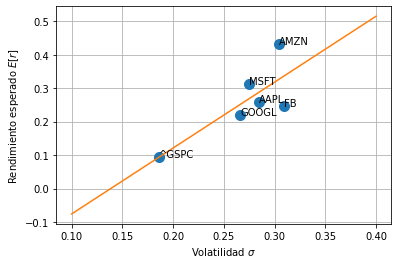

In [68]:
# Gráfico rendimiento esperado vs. volatilidad
import matplotlib.pyplot as plt
%matplotlib inline
# Puntos a graficar
# Ventana para graficar
plt.figure(figsize=(6,4))
# Graficar puntos
plt.plot(resumen_anual['Vol'],resumen_anual['R.E'],'o',ms=10)
# Etiquetas de los ejes
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento esperado $E[r]$')
# Etiqueta de cada instrumento
for i in range(len(resumen_anual)):
    plt.text(resumen_anual.iloc[i,1],resumen_anual.iloc[i,0],resumen_anual.index[i])

# Gráfica de la recta ajustada
vol = np.linspace(.1,.4)
plt.plot(vol,beta[0] + beta[1]*vol,label=f'Recta Ajustada $E[r]=${np.round(beta[0],2)}$+${np.round(beta[1],2)}*$\sigma$')
plt.grid()

**¿Qué se puede concluir acerca de la relación entre riesgo (medido con la volatilidad) y el rendimiento esperado (medido con la media)?**

Respuestas:
- Para un rendimiento esperado más alto, se necesita asumir más riesgo.
- La relación entre rendimiento esperado y riesgo es positiva (de acuerdo a los datos).

## 3. Comentarios finales acerca del uso de datos históricos.

### ¡Cuidado!
- Es cierto que los patrones que vemos sobre periodos largos de tiempo en diferentes tipos de intrumentos son muy robustos en términos de la relación rendimiento/riesgo (positiva).
- Por tanto, esperamos rendimientos más altos en el futuro cuando asumimos cierto riesgo.
- ¿Cómo encontramos ese 'rendimiento esperado' en el futuro'? Datos históricos (humanos: tendencia a generalizar)

- Entonces, la idea es que si los rendimientos esperados son un p.e. estacionario, el promedio de muchos rendimientos pasados es una buena estimación del rendimiento esperado futuro (Teorema del límite central).
- ¿Deberíamos pensarlo dos veces?

## SI

Problemas:
- La muestra de datos en el periodo específico de tiempo puede estar sesgada.
- Ventanas de tiempo más grandes reducen especificidad de la muestra y estimados más precisos.
 - Aún así, datos muy viejos pueden ser no representativos.
- Nuevos fondos o estrategias de inversión están a menudo sesgados positivamente:
 - reporte de resultados en tiempos voluntarios;
 - las que mueren (no funcionan), no se reportan;

# Anuncios parroquiales:
## 1. Fin Módulo 1. Revisar que se hayan cumplido los objetivos del módulo (Clase0)
## 2. Tarea: revisar archivo "Tarea3_MidiendoRendimientoRiesgo" en clase. Para ...
## 3. Recordar quiz la siguiente clase.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>